In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import logsumexp

In [44]:
class Score_Sampler():
    def __init__(self, bmin = 1.0, bmax = 1.0):
        self.bmin = bmin
        self.bmax = bmax

    def beta_funtion(self,t):
        bmin = self.bmin
        bmax = self.bmax
        return bmin + (bmax - bmin)*t

    def beta_funtion_integral(self, t):
        bmin = 1.0
        bmax = 1.0
        return bmin*t + (bmax - bmin)*(t**2)/2

    def compute_a(self, t):
        beta_integral = self.beta_funtion_integral(t)
        return np.exp(- 0.5 * beta_integral) + 1e-5

    def compute_sigma(self, t):
        beta_integral = self.beta_funtion_integral(t)
        return np.sqrt(1 - np.exp( - beta_integral)) + 1e-5

    def MC_estimator_score(self, t, X, pi, sample_size):
        pass

    def sample(self, pi, dim, batch_size, T = 3, N = 1000):
        X = np.random.normal(size = (batch_size, dim))
        dt = T/N
        for i in range(0, N):
            t = dt * i
            score = self.MC_estimator_score(T - t, X, pi)
            beta = self.beta_funtion(T - t)
            drift = beta * X / 2 + beta * score
            vol = np.sqrt(beta)
            dW =  np.sqrt(dt)*np.random.normal(size = (batch_size, dim)) 
            X = X + drift*dt + vol*dW
        return X 

In [133]:
class Log_Expansion_Score(Score_Sampler):
    def __init__(self, sample_size_grad = 500, sample_size_inverse = 50, sample_size_N = 10, bmin=1, bmax=1, p = 1/2):
        super().__init__(bmin = bmin, bmax = bmax)
        self.sample_size_grad = sample_size_grad
        self.sample_size_inverse = sample_size_inverse
        self.sample_size_N = sample_size_N
        self.p = p

    def MC_estimator_grad_pi_t(self, pi, X, a, sigma, sample_size):
        '''
        Estimate for E[Z \pi(X0)/(sigma)] where X0 = (sigma*Z + X)/a and Z starndar normal 

        Parameter:
            pi (funtion): (M, L, N) -> (M, L, 1)
            X  (array):   (L, N)
            a  (Float)
            sigma (Float)
            Sample_size (int)

        return:
            array:  (L, N)
        '''
        batch_size = X.shape[0]
        dim_X = X.shape[1]
        Z = np.random.randn(sample_size, batch_size, dim_X)
        X0 = (sigma * Z + X)/a
        # Aplicar pi em X0
        pi_X0 = pi(X0)
        pi_X0 = pi_X0
        expression = (Z * pi_X0) / sigma
        MC = np.mean(expression, axis = 0)
        return MC

    def unbiease_estimator_pi_t(self, pi, X, a, sigma, sample_size):
        '''
        Estimate for E[\pi(X0)] where X0 = (sigma*Z + X)/a and Z starndar normal 
        Parameter:
            pi (funtion): (M, L, N) -> (M, L, 1)
            X  (array):   (L, N)
            a  (Float)
            sigma (Float)
            Sample_size (int)

        return:
            np.array (L,1)
        '''
        batch_size = X.shape[0]
        dim_X = X.shape[1]
        Z = np.random.randn(sample_size, batch_size, dim_X)
        X0 = (sigma * Z + X)/a
        # Aplicar pi em X0
        pi_X0 = pi(X0)
        MC = np.mean(pi_X0, axis = 0)
        return MC
    
    def one_step_MC_inverse_density(self, pi, X, a, sigma, sample_size):
        p = self.p
        N = np.random.geometric(1-p) - 1
        random_produc = X*0.0 + 1.0 # vários 1 com o shape de X
        for _ in range(N):
            random_produc *= (1 - self.unbiease_estimator_pi_t(pi, X, a, sigma, sample_size))/p
        pi_inverse = random_produc/(1-p)
        return pi_inverse

    def MC_estimator_inverse_pi_t(self, pi, X, a, sigma, sample_size):
        sample_N_size = self.sample_size_N
        aux_compute_mean = np.stack([self.one_step_MC_inverse_density(pi, X, a, sigma, sample_size) for _ in range(sample_N_size)])
        pi_inverse = np.mean(aux_compute_mean, axis = 0)
        # pi_inverse =  np.sum([(1 - self.unbiease_estimator_pi_t(pi, X, a, sigma, sample_size))**j for j in range(100)], axis = 0)
        return pi_inverse

    def MC_estimator_score(self, t, X, pi):
        a = self.compute_a(t)
        sigma = self.compute_sigma(t)
        grad_pi = self.MC_estimator_grad_pi_t(pi, X, a, sigma, self.sample_size_grad)
        pi_inverse = self.MC_estimator_inverse_pi_t(pi, X, a, sigma, self.sample_size_inverse)
        return grad_pi*pi_inverse

In [134]:
def pi_normal(X):
    mean = 0.0
    var = 1.0
    density = np.exp(- (X - mean)**2/(2*var))
    return density

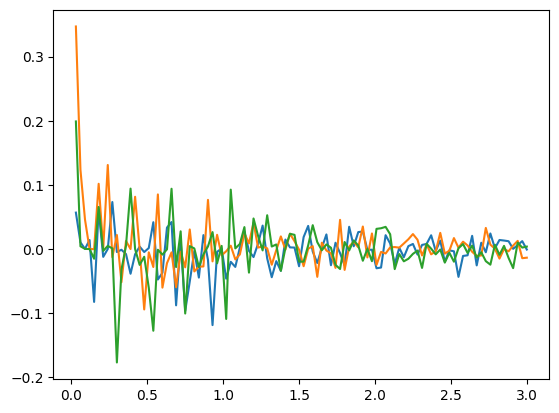

In [154]:
T = 3
N = 100
X = np.array([[0.]])
sampler = Log_Expansion_Score(p = 0.9)
times = [i*T/N for i in range(1, N+1)]
score1 = [sampler.MC_estimator_score(t, X, pi_normal)[0,0] for t in times]
score2 = [sampler.MC_estimator_score(t, X, pi_normal)[0,0] for t in times]
score3 = [sampler.MC_estimator_score(t, X, pi_normal)[0,0] for t in times]
plt.plot(times, score1)
plt.plot(times, score2)
plt.plot(times, score3)

<Axes: ylabel='Density'>

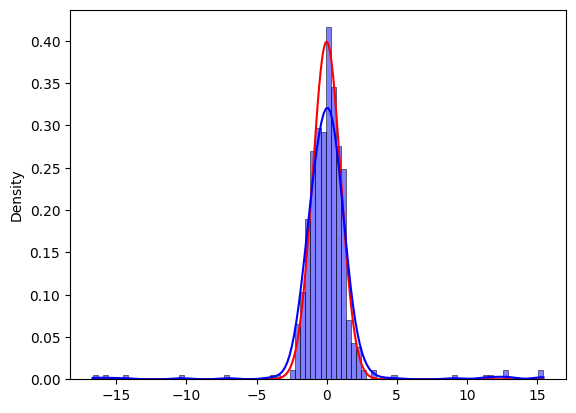

In [155]:
sampler = Log_Expansion_Score(p = 0.9, sample_size_inverse=200)
data = sampler.sample(pi_normal, 1, 512)[:,0]
x = np.linspace(min(data), max(data), 1000)
y = norm.pdf(x, 0, 1)
plt.plot(x, y, color="red", label="Densidade Normal")
sns.histplot(data, stat = "density", kde = True, color="blue")

In [143]:
data.mean()

np.float64(-0.18106281452417455)

In [151]:
data.sort()
data[20:490].var()

np.float64(0.8066626271157293)

In [153]:
data.var()

np.float64(7.698510625660747)

In [156]:
def pi_normal(X):
    mean = 2.0
    var = 0.3
    density = np.exp(- (X - mean)**2/(2*var))
    return density

<Axes: ylabel='Density'>

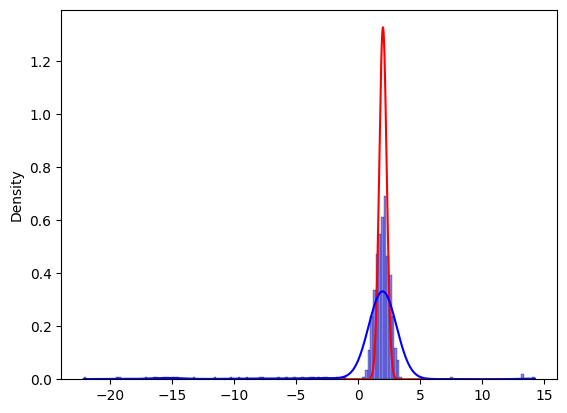

In [157]:
sampler = Log_Expansion_Score(p = 0.9, sample_size_inverse=200)
data = sampler.sample(pi_normal, 1, 512)[:,0]
x = np.linspace(min(data), max(data), 1000)
y = norm.pdf(x, 2.0, 0.3)
plt.plot(x, y, color="red", label="Densidade Normal")
sns.histplot(data, stat = "density", kde = True, color="blue")

<Axes: ylabel='Density'>

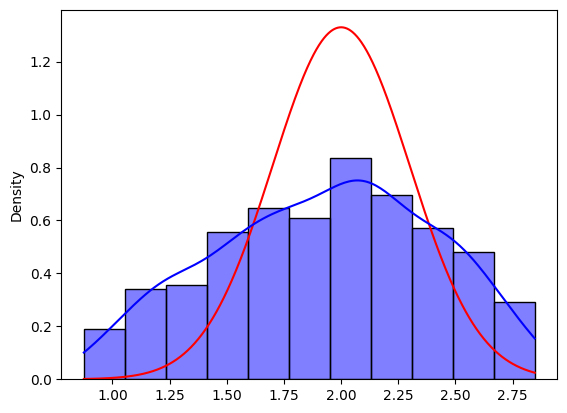

In [158]:
data.sort()
data1 = data[40:480]
x = np.linspace(min(data1), max(data1), 1000)
y = norm.pdf(x, 2.0, 0.3)
plt.plot(x, y, color="red", label="Densidade Normal")
sns.histplot(data1, stat = "density", kde = True, color="blue")